###  점

In [30]:
import warnings
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, Activation, regularizers
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils, to_categorical
from keras import backend as K
from keras import optimizers

In [17]:
# load dataset list

train_data = pd.read_csv("train_vision.csv")
train_filename = train_data["filename"].values.tolist()
train_data["label"] = train_data["label"] -1
train_label = train_data["label"].values.tolist()

test_data = pd.read_csv("test_vision.csv")
test_filename = test_data["filename"].values.tolist()

print(len(train_filename), len(train_label), len(test_filename))

5850 5850 2000


In [18]:
# load train data
input_height , input_width = 128, 128
n_class = 6

def getImageArr(img_name):
        img = cv2.imread("faces_images/" + img_name, 1)
        img = np.float32(img) / 255  #0~255 를 평균 0이게 수정
        return img

X = []
for name in train_filename:
    X.append(getImageArr(name))
    
X, Y = np.array(X), to_categorical(np.array(train_label),n_class)
print(X.shape, Y.shape)

(5850, 128, 128, 3) (5850, 6)


In [19]:
# split dataset

train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
# X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4972, 128, 128, 3) (4972, 6)
(878, 128, 128, 3) (878, 6)


In [20]:
# load test data

real_test = []
for name in test_filename:
    real_test.append(getImageArr(name))
    
real_test = np.array(real_test)
print(real_test.shape)

(2000, 128, 128, 3)


In [45]:
 def nn_base(nClasses, input_height=128, input_width=128):
        
    img_input = Input(shape=(input_height,input_width, 3))
        
    IMAGE_ORDERING =  "channels_last"
    
    x = Conv2D(32,(3, 3),padding='same', name='image_array', data_format=IMAGE_ORDERING)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64,(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format=IMAGE_ORDERING )(x)
    x = Dropout(.25)(x)

    x = Conv2D(64,(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), data_format=IMAGE_ORDERING )(x)
    x = Dropout(.25)(x)

    x = Conv2D(128,(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128,(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format=IMAGE_ORDERING )(x)
    x = Dropout(.25)(x)
    
    x = Flatten(name='flatten')(x)
    
    x = Dense(2048, activation='relu', name='fc2')(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    
    x = Dense(512, activation='relu', name='fc3')(x)
    x = BatchNormalization()(x)
    x = Dropout(.3)(x)
    
    x = Dense(n_class , activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x)

    return model

In [46]:
model = nn_base(nClasses  = n_class,  
             input_height = 128, 
             input_width  = 128)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
image_array (Conv2D)         (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_94 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_50 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 42, 42, 64)        18496     
__________

In [47]:
learing_rate = 1E-3
epoch = 25
with K.tf.device('/gpu:1'):
    adam = optimizers.Adam(lr=learing_rate, decay=learing_rate/100)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

    hist1 = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      batch_size=32,epochs=epoch)

Train on 4972 samples, validate on 878 samples
Epoch 1/25
4972/4972 [==============================] - 12s 2ms/step - loss: 1.8293 - acc: 0.4290 - val_loss: 1.1147 - val_acc: 0.5683
Epoch 2/25
4972/4972 [==============================] - 5s 1ms/step - loss: 1.0745 - acc: 0.6167 - val_loss: 0.7373 - val_acc: 0.7335
Epoch 3/25
4972/4972 [==============================] - 5s 1ms/step - loss: 0.7989 - acc: 0.7120 - val_loss: 1.8712 - val_acc: 0.3428
Epoch 4/25
4972/4972 [==============================] - 5s 1ms/step - loss: 0.6344 - acc: 0.7683 - val_loss: 0.7207 - val_acc: 0.7255
Epoch 5/25
4972/4972 [==============================] - 5s 1ms/step - loss: 0.5446 - acc: 0.8017 - val_loss: 0.5048 - val_acc: 0.8360
Epoch 6/25
4972/4972 [==============================] - 5s 1ms/step - loss: 0.4625 - acc: 0.8363 - val_loss: 0.3650 - val_acc: 0.8815
Epoch 7/25
4972/4972 [==============================] - 5s 1ms/step - loss: 0.4261 - acc: 0.8459 - val_loss: 0.5285 - val_acc: 0.8155
Epoch 8/25
497

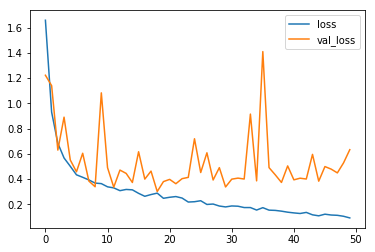

In [41]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [11]:
y_pred = model.predict(real_test)
y_predi = np.argmax(y_pred,axis = 1) + 1
print(np.unique(y_predi), y_predi.shape)

[1 2 3 4 5 6] (2000,)


In [12]:
answer = pd.DataFrame({"prediction":y_predi})

In [13]:
answer.to_csv('results/6-5.csv',index=False, header="label")